# ***Project Name*** - Explainable AI for Medical Image Segmentation Using **Grad-CAM** for Linknet

## **Group - 2**
## **Team Members -**


### 1.   Srirama Rama Sai Mehar
### 2.   Himanshi Agarwal
### 3.   Sai Sumanth V



## **Loading Dataset**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sreeramaramasaimehar","key":"3032babdcbd9a3e18aac1f3d01a80e0d"}'}

In [ ]:
!kaggle datasets download -d abdallahwagih/kvasir-dataset-for-classification-and-segmentation

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation
License(s): CC0-1.0
100% 1.20G/1.20G [00:13<00:00, 125MB/s]
100% 1.20G/1.20G [00:13<00:00, 96.9MB/s]


In [ ]:
!unzip /content/kvasir-dataset-for-classification-and-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/00687a70-bbad-4bf9-864f-9f7b3c27a2c8.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/0134d93d-0922-4063-9acd-a4177f2b0c07.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/01a57b1a-780f-4e52-9f94-291c2982154d.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/01f092a2-fccb-49f6-af06-8351c8bb47f1.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/022b40a7-a36f-4510-95a1-b6bb709e94ed.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/02b1d319-dea6-418b-969a-c588585cb4f2.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/02de4b4c-8704-45f7-b90f-6004d76bdded.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/0339a2f7-65bb-41fb-8650-e119670b4e2e.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/03ccdf30-eac8-4e3b-b8e5-54fbf64709dd.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/03ea76c5-d60

## **Importing Libraries**

In [ ]:
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Add
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


 Getting name of image files and appending it to a list.

In [ ]:
IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT = 3, 512, 512

In [ ]:
X = next(os.walk('/content/kvasir-seg/Kvasir-SEG/images'))[2]
y = next(os.walk('/content/kvasir-seg/Kvasir-SEG/masks'))[2]

In [ ]:
X_ids = X[:]
y_ids = y[:]

print(len(X_ids))

1000


In [ ]:
X_tr = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_tr = np.zeros((len(y_ids), 256, 256, 1), dtype=np.bool_)

## **Pre-Processing**

In [ ]:
X_train = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_train = np.zeros((len(y_ids), 256, 256, 1), dtype=np.bool_)

for n, id_ in enumerate(X_ids):
    image = tf.keras.preprocessing.image.load_img(f'/content/kvasir-seg/Kvasir-SEG/images/{id_}', target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr, ).resize((256, 256))
    X_train[n] = np.array(image)

for n, id_ in enumerate(y_ids):
    image = tf.keras.preprocessing.image.load_img(f'/content/kvasir-seg/Kvasir-SEG/masks/{id_}',
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr).resize((256, 256))
    y_train[n] = np.array(image)[:, :, np.newaxis]

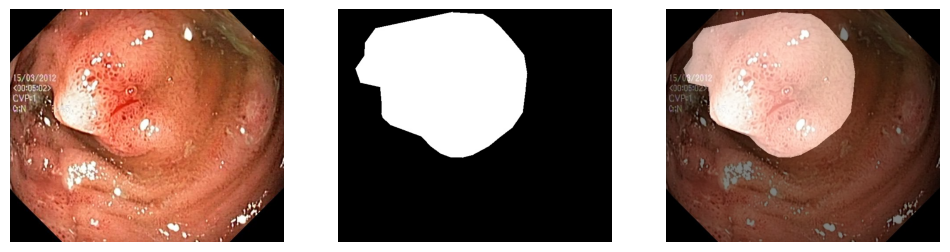

In [ ]:
plt.figure(figsize=(12, 8))
img=cv2.imread('/content/kvasir-seg/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg')
msk=cv2.imread('/content/kvasir-seg/Kvasir-SEG/masks/cju0qkwl35piu0993l0dewei2.jpg')

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB))
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB),alpha=0.5)
plt.axis(False)
plt.show()

## **Linknet**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU, SpatialDropout2D, Add
import tensorflow as tf

def BuildingBlock(x, filters, kernel_size, stride=1, padding='same'):
    if stride > 1:
        residual = Conv2D(filters, kernel_size=1, strides=stride)(x)
        residual = BatchNormalization()(residual)
    else:
        residual = x

    out = Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    out = BatchNormalization()(out)
    out = LeakyReLU(alpha=0.1)(out)  # Thay đổi ReLU thành LeakyReLU
    out = Conv2D(filters, kernel_size, strides=1, padding=padding)(out)
    out = BatchNormalization()(out)

    out = Add()([out, residual])
    out = LeakyReLU(alpha=0.1)(out)  # Thay đổi ReLU thành LeakyReLU
    return out

def EncoderBlock(x, filters, kernel_size, stride=1, padding='same'):
    x = BuildingBlock(x, filters, kernel_size, stride, padding)
    x = BuildingBlock(x, filters, kernel_size, stride=1, padding=padding)

    return x

def DecoderBlock(x, in_channels, filters, kernel_size, stride=1, padding='same', output_padding=(0, 0)):
    x = Conv2D(in_channels//4, kernel_size=1, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)  # Thay đổi ReLU thành LeakyReLU

    x = Conv2DTranspose(in_channels//4, kernel_size, strides=stride, padding=padding, output_padding=output_padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)  # Thay đổi ReLU thành LeakyReLU

    x = Conv2D(filters, kernel_size=1, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)  # Thay đổi ReLU thành LeakyReLU

    return x


def LinkNet():
    inputs = Input(shape=(256, 256, 3))

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)  # Thay đổi ReLU thành LeakyReLU
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = Dropout(0.25)(x)

    e1 = EncoderBlock(x, filters=64, kernel_size=3, stride=1, padding='same')
    e2 = EncoderBlock(e1, filters=128, kernel_size=3, stride=2, padding='same')
    e3 = EncoderBlock(e2, filters=256, kernel_size=3, stride=2, padding='same')
    e4 = EncoderBlock(e3, filters=256, kernel_size=3, stride=2, padding='same')
    e5 = EncoderBlock(e4, filters=512, kernel_size=3, stride=2, padding='same')
    e6 = EncoderBlock(e5, filters=512, kernel_size=3, stride=2, padding='same')
    e7 = EncoderBlock(e6, filters=512, kernel_size=3, stride=2, padding='same')


    d7 = DecoderBlock(e7, in_channels=512, filters=512, kernel_size=3, stride=2, padding='same', output_padding=(1, 1)) + e6
    d6 = DecoderBlock(d7, in_channels=512, filters=512, kernel_size=3, stride=2, padding='same', output_padding=(1, 1)) + e5
    d5 = DecoderBlock(d6, in_channels=512, filters=256, kernel_size=3, stride=2, padding='same', output_padding=(1, 1)) + e4
    d4 = DecoderBlock(d5, in_channels=256, filters=256, kernel_size=3, stride=2, padding='same', output_padding=(1, 1)) + e3
    d3 = DecoderBlock(d4, in_channels=256, filters=128, kernel_size=3, stride=2, padding='same', output_padding=(1, 1)) + e2
    d2 = DecoderBlock(d3, in_channels=128, filters=64, kernel_size=3, stride=2, padding='same', output_padding=(1, 1)) + e1

    y = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', output_padding=(1, 1))(d2)
    y = BatchNormalization()(y)
    y = LeakyReLU(alpha=0.1)(y)  # Thay đổi ReLU thành LeakyReLU

    y = Conv2D(32, kernel_size=3, strides=1, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU(alpha=0.1)(y)  # Thay đổi ReLU thành LeakyReLU
    y = Dropout(0.25)(y)

    y = Conv2DTranspose(1, kernel_size=2, strides=2, padding='valid')(y)
    y = Activation('sigmoid')(y)

    model = Model(inputs=inputs, outputs=y)
    return model

In [ ]:
def iou(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, dtype='float32')  # Convert y_true to float32
    y_pred = K.cast(y_pred, dtype='float32')  # Convert y_pred to float32
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [ ]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (1000, 256, 256, 3), y_train shape: (1000, 256, 256, 1)


In [ ]:
model = LinkNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 128, 128, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_110   │ (None, 128, 128, 64)   │            256 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_98            │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 64)     │              0 │ leaky_re_lu_98[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64, 64, 64)     │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_111   │ (None, 64, 64, 64)     │            256 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_99            │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ leaky_re_lu_99[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_112   │ (None, 64, 64, 64)     │            256 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_40 (Add)              │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_100           │ (None, 64, 64, 64)     │              0 │ add_40[0][0]           │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ leaky_re_lu_100[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_113   │ (None, 64, 64, 64)     │            256 │ conv2d_99[0][0]        │
│ (BatchNormalization) 

 Total params: 34,037,825 (129.84 MB)

 Trainable params: 34,009,665 (129.74 MB)

 Non-trainable params: 28,160 (110.00 KB)

## **Training the model**

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=120)

Epoch 1/120
57/57 ━━━━━━━━━━━━━━━━━━━━ 116s 870ms/step - accuracy: 0.6331 - iou: 0.2878 - loss: 0.6370 - val_accuracy: 0.2585 - val_iou: 0.2445 - val_loss: 553.8046
Epoch 2/120
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.7433 - iou: 0.3031 - loss: 0.5216 - val_accuracy: 0.2578 - val_iou: 0.2444 - val_loss: 1063.6355
Epoch 3/120
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.7624 - iou: 0.3226 - loss: 0.4952 - val_accuracy: 0.3743 - val_iou: 0.2695 - val_loss: 26.7114
Epoch 4/120
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.7750 - iou: 0.3363 - loss: 0.4735 - val_accuracy: 0.5475 - val_iou: 0.2938 - val_loss: 3.8528
Epoch 5/120
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.7960 - iou: 0.3622 - loss: 0.4461 - val_accuracy: 0.6619 - val_iou: 0.3206 - val_loss: 1.1063
Epoch 6/120
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.8031 - iou: 0.3733 - loss: 0.4393 - val_accuracy: 0.7513 - val_iou: 0.3118 - val_loss: 0.9302
Epoch 7/120
57/57 ━━━━━

### **Plotting history:**

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou']
#     tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou']
#     val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(val_iou)
    iou_highest = val_iou[index_iou]

#     index_dice = np.argmax(dice_coef)
#     dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
#     dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_vl = f'best Acc= {str(acc_highest)}'
    iou_vl = f'best Iou= {str(iou_highest)}'
    loss_vl = f'best loss= {str(val_lowest)}'
    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_vl)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_vl)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_vl)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()


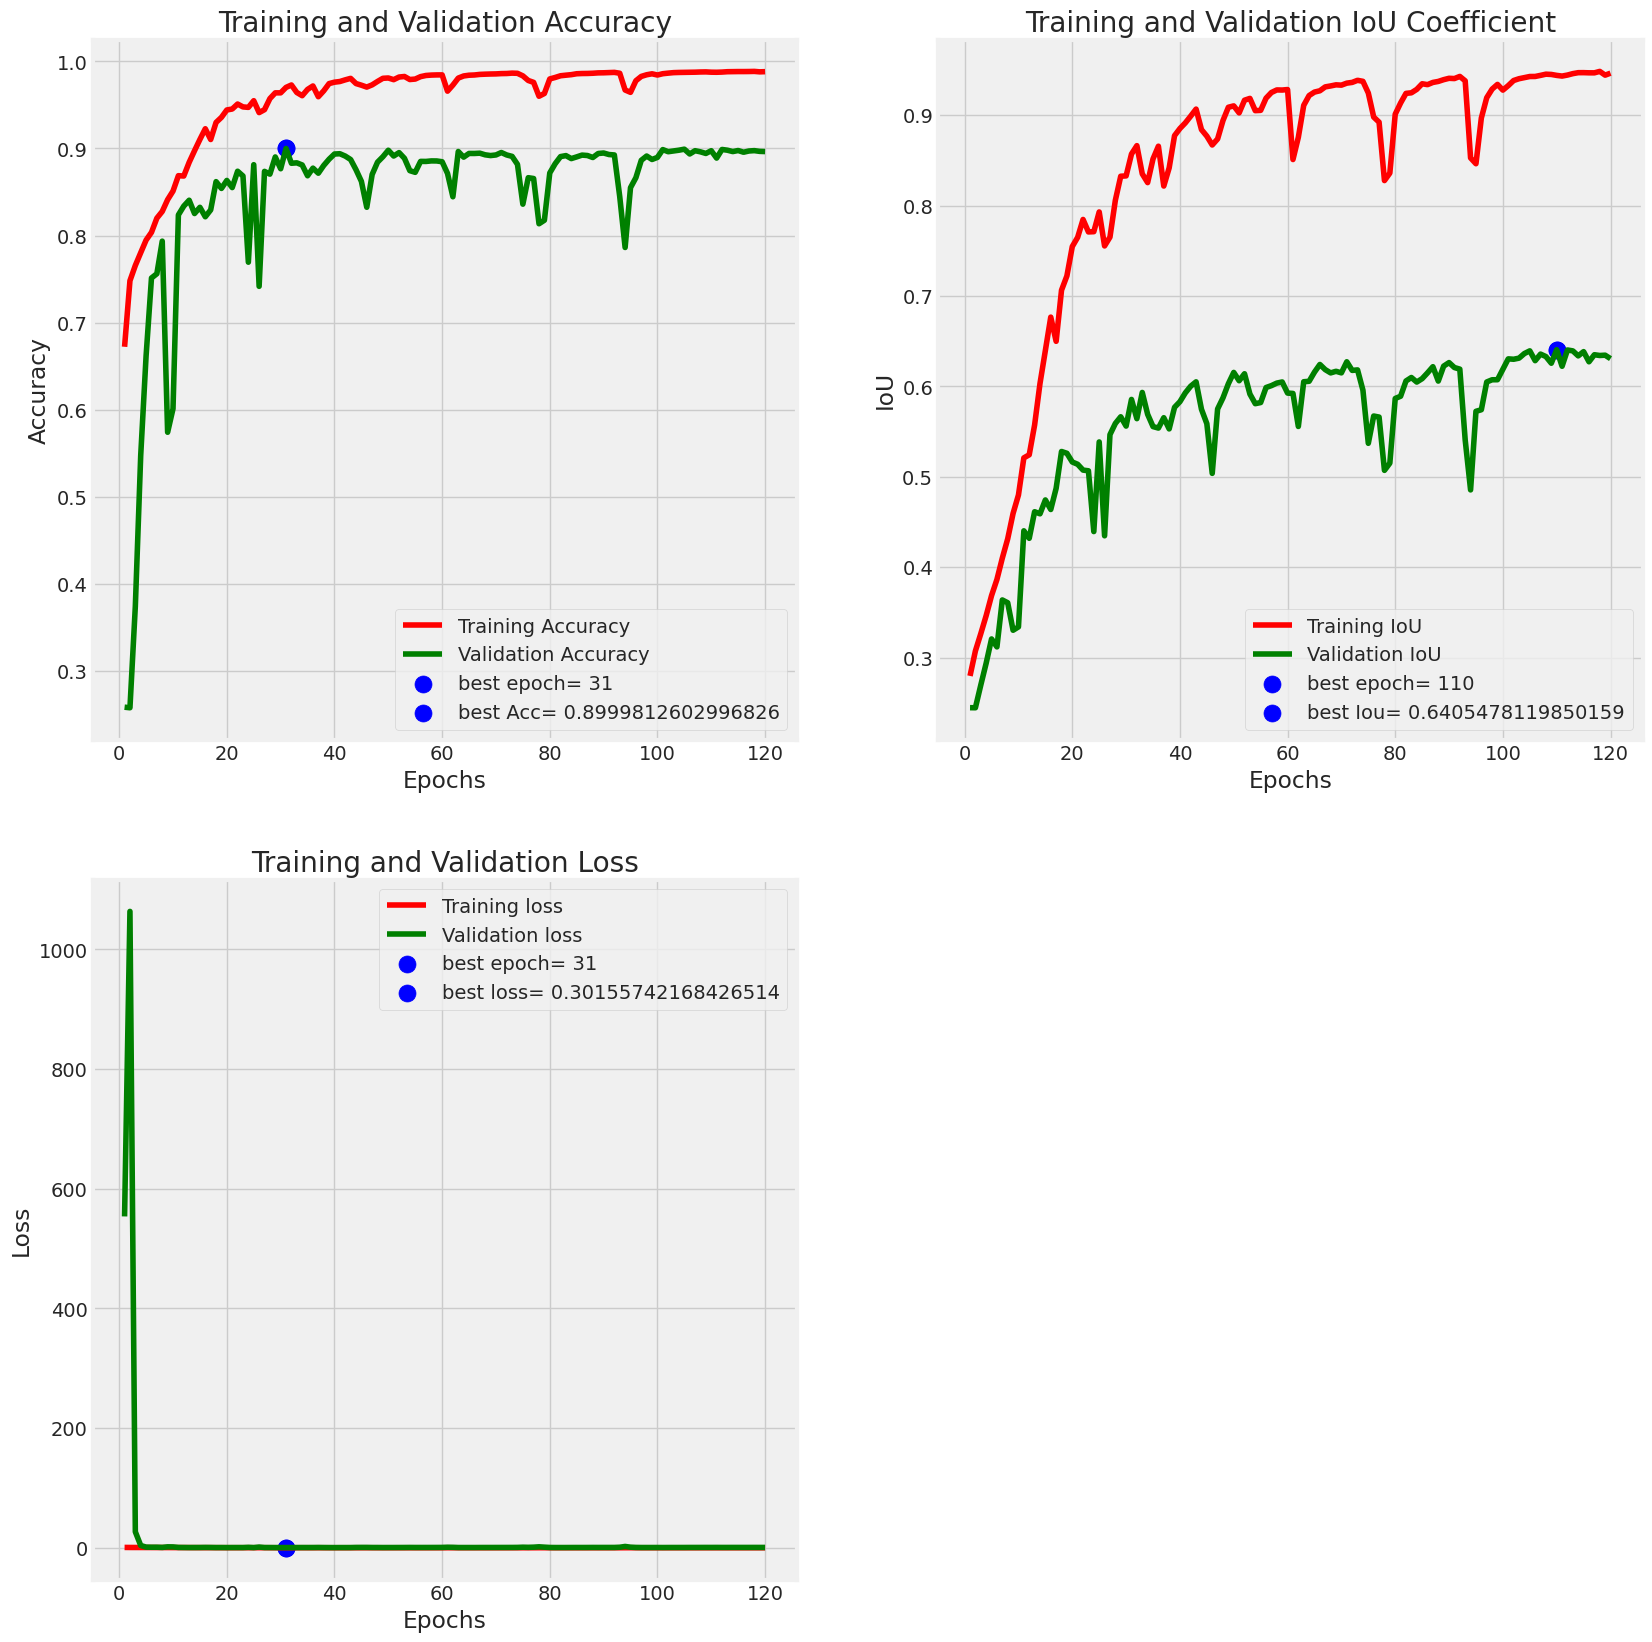

In [ ]:
plot_training(history)

## **Predicted Image**

In [ ]:
img = tf.keras.preprocessing.image.load_img(r"/content/kvasir-seg/Kvasir-SEG/images/cju0s2a9ekvms080138tjjpxr.jpg", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


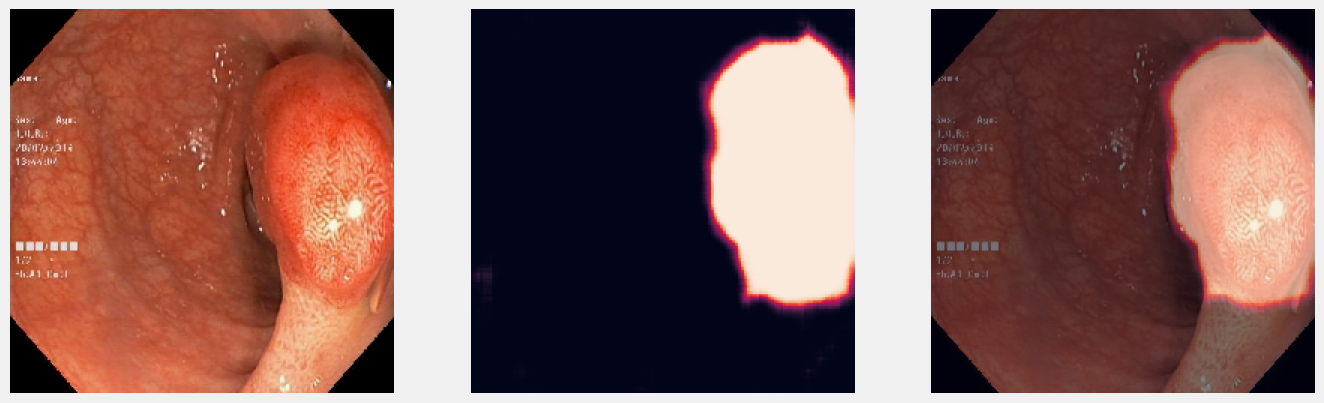

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()

In [ ]:
subject = 'Kvasir Linknet Segmentation'
save_path = './'


save_id = str(f'{subject} model.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as ./Kvasir Linknet Segmentation model.h5


## **Model Testing**

In [ ]:
def iou(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, dtype='float32')  # Convert y_true to float32
    y_pred = K.cast(y_pred, dtype='float32')  # Convert y_pred to float32
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU, SpatialDropout2D, Add
import tensorflow as tf

In [ ]:
segmentation_model = load_model('Kvasir Segmentation model.h5', compile=False)
segmentation_model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', iou])

In [ ]:
# Preprocess the image for segmentation
def preprocess_segmentation_image(image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    image = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    img = cv2.resize(image, (256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]

In [ ]:
img = tf.keras.preprocessing.image.load_img(r"/content/kvasir-seg/Kvasir-SEG/images/cju0qoxqj9q6s0835b43399p4.jpg", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Converting image to a batch.
predictions = segmentation_model.predict(input_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


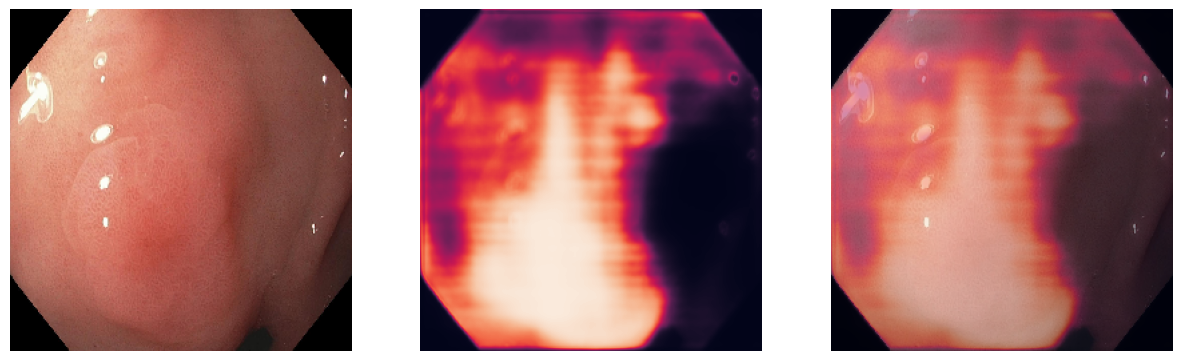

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Function to load and preprocess a single image
def load_and_preprocess_image(filepath, target_size=(256, 256)):
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=target_size)
    input_array = tf.keras.preprocessing.image.img_to_array(img)
    input_array = np.expand_dims(input_array, axis=0)  # Convert to a batch of 1
    return img, input_array

# Path to the images folder
images_folder = "/content/kvasir-seg/Kvasir-SEG/images/"
all_images = os.listdir(images_folder)

# Select 10-15 random images
num_images = 15  # Change this to your desired number
random_images = random.sample(all_images, num_images)

# Set up the plot grid
plt.figure(figsize=(20, num_images * 4))
for i, image_name in enumerate(random_images):
    image_path = os.path.join(images_folder, image_name)

    # Load and preprocess the image
    original_img, input_array = load_and_preprocess_image(image_path)

    # Get the model prediction
    predictions = segmentation_model.predict(input_array)
    predicted_mask = np.squeeze(predictions)

    # Plot original image
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(original_img)
    plt.axis("off")
    plt.title("Original Image")

    # Plot prediction mask
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(predicted_mask, cmap="gray")
    plt.axis("off")
    plt.title("Predicted Mask")

    # Overlay prediction on original
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(original_img)
    plt.imshow(predicted_mask, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay")

plt.tight_layout()
plt.show()


## **Grad-Cam**

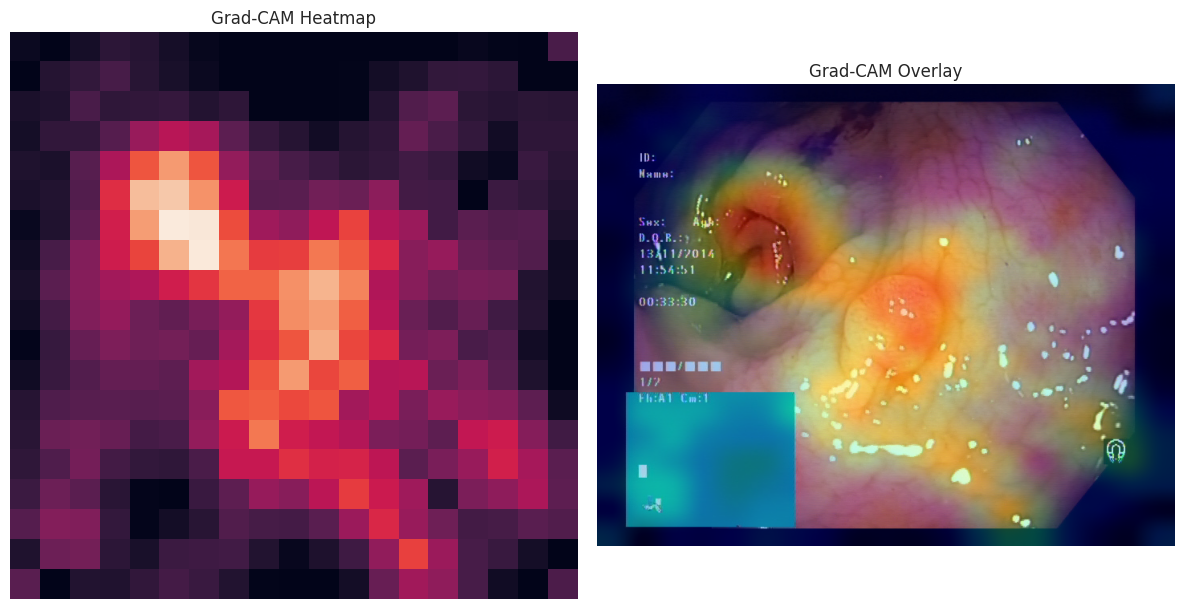

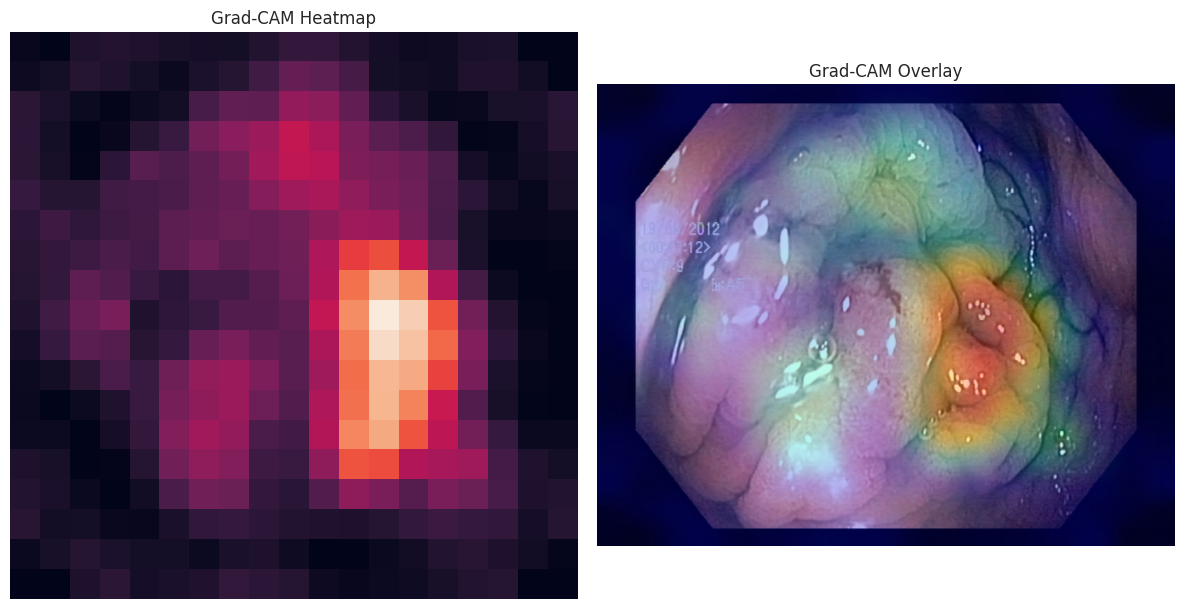

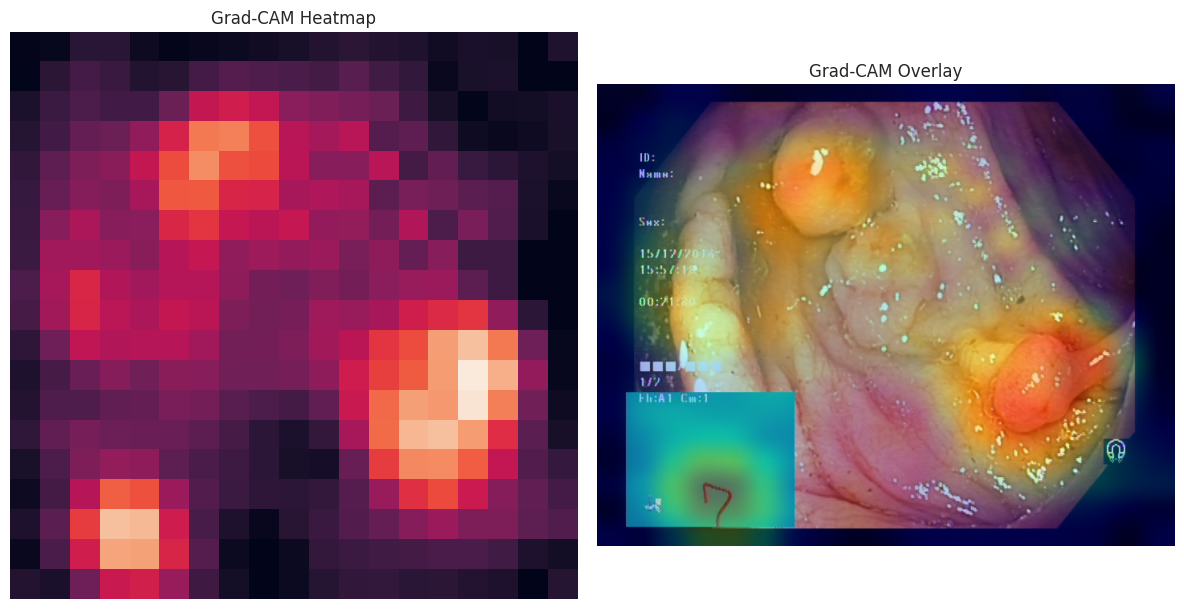

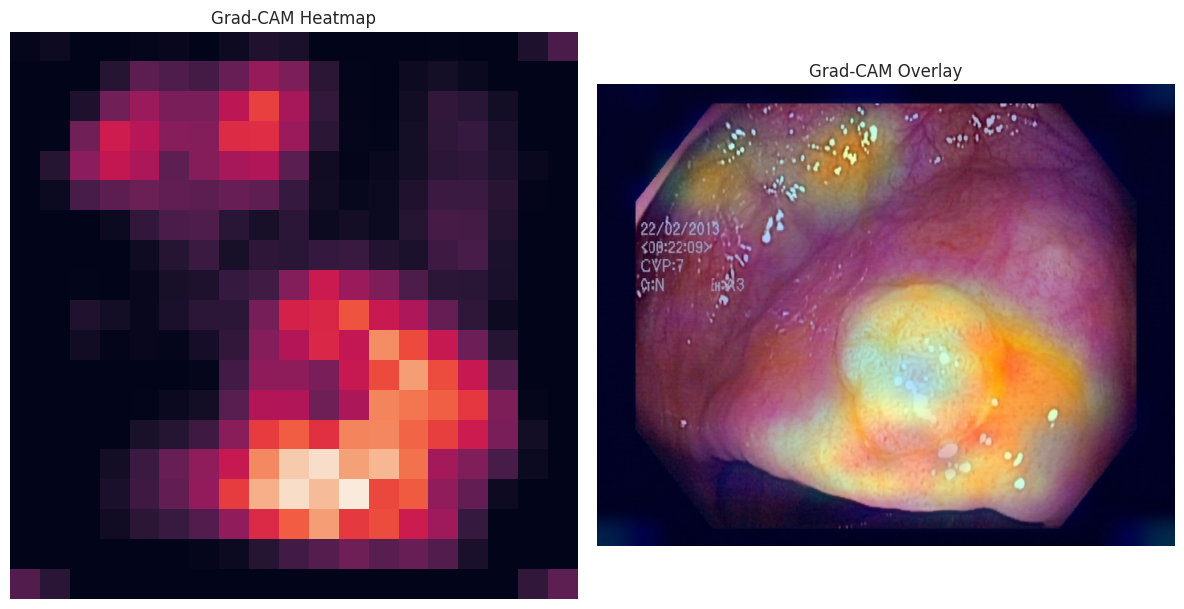

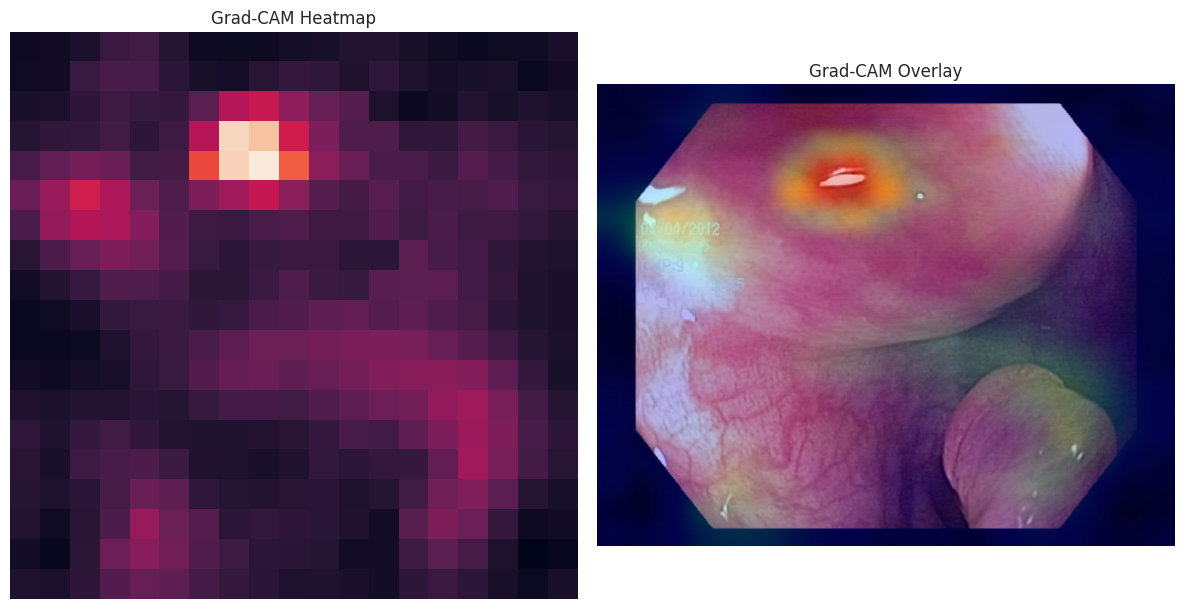

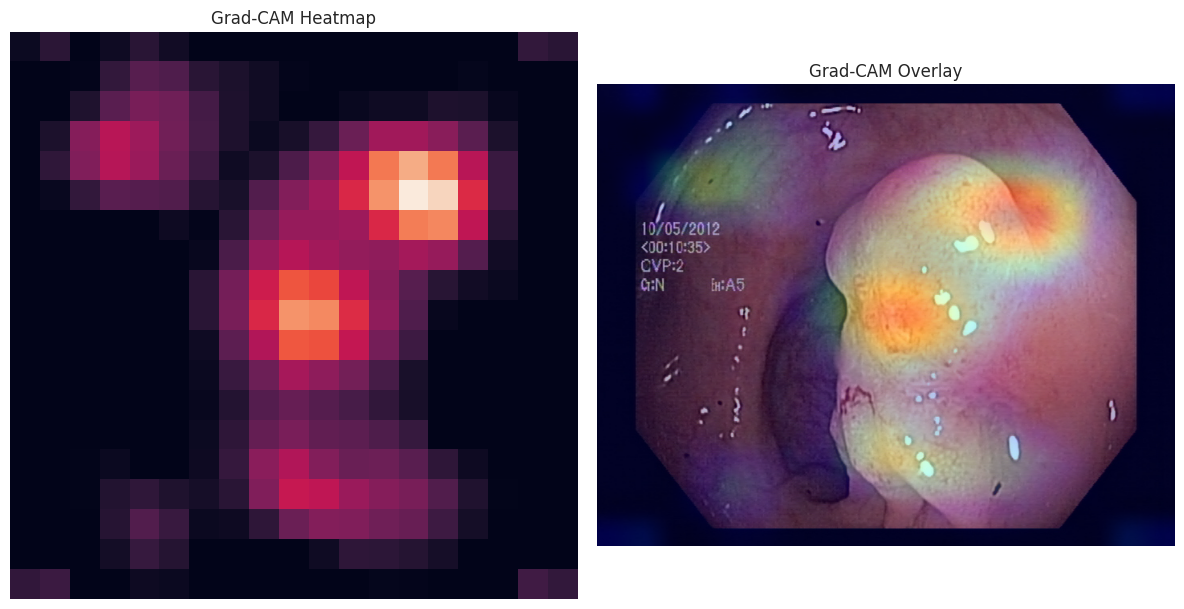

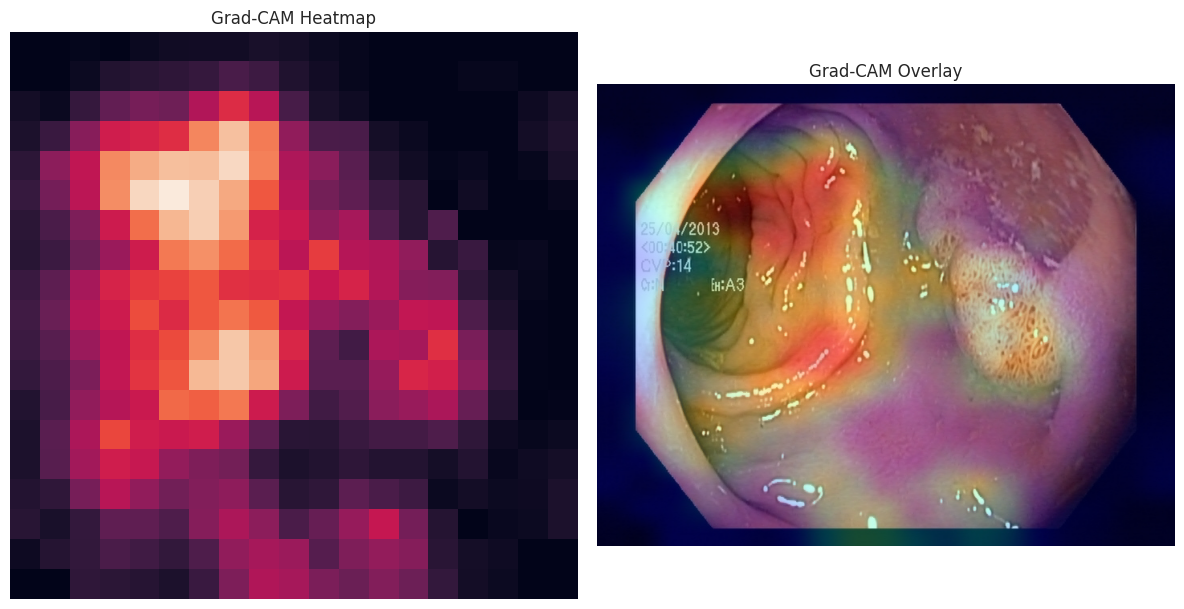

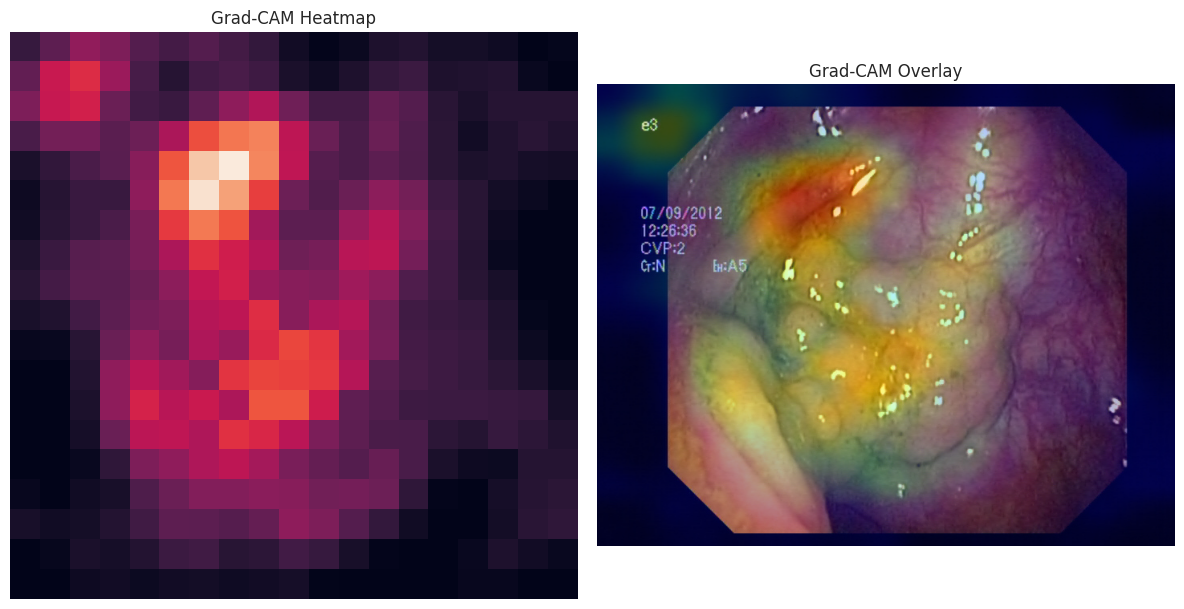

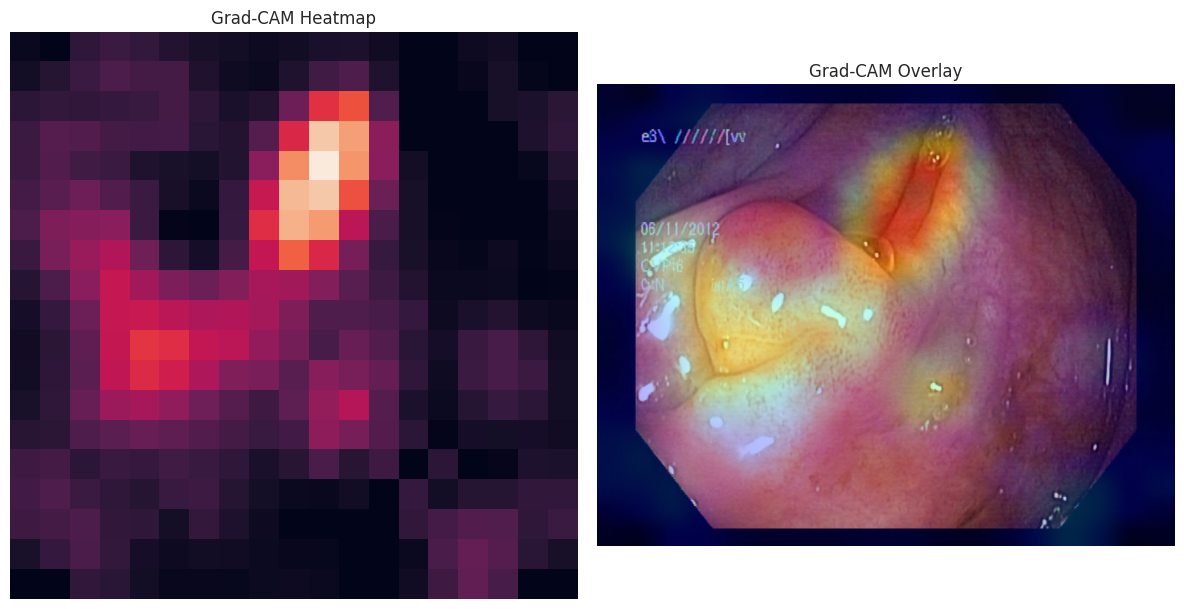

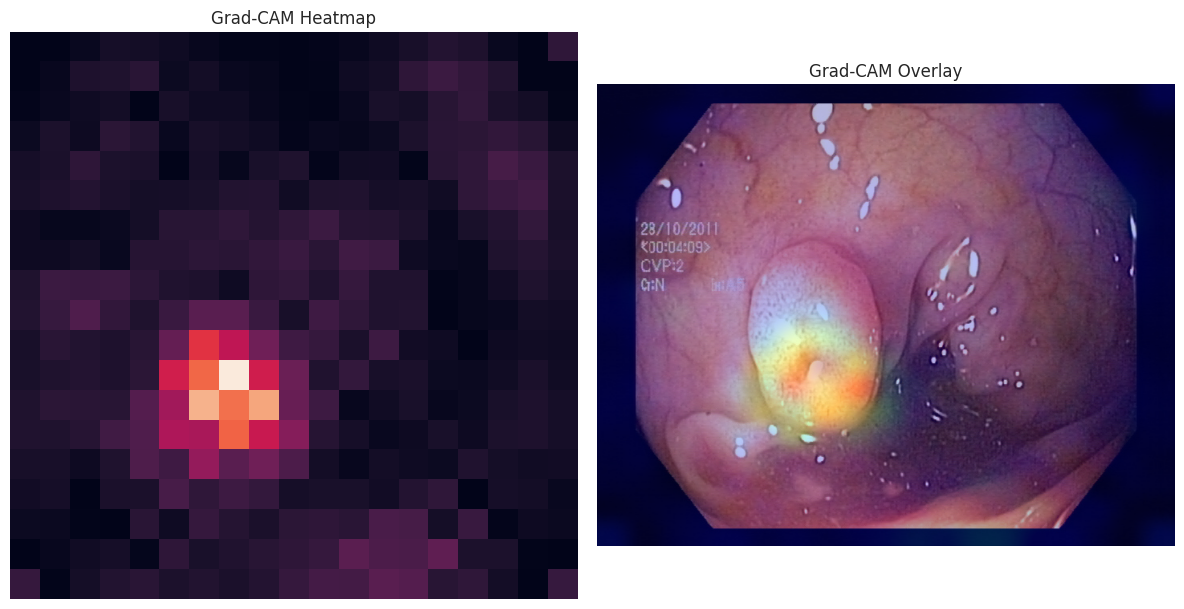

Grad-CAM processing completed for 10 images.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import matplotlib as mpl

# Function to preprocess the input image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to save and display Grad-CAM output side by side
def save_and_display_gradcam_side_by_side(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = mpl.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Create figure for side-by-side display
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display Heatmap
    axes[0].imshow(heatmap)
    axes[0].set_title("Grad-CAM Heatmap")
    axes[0].axis('off')

    # Display Grad-CAM Overlay
    axes[1].imshow(superimposed_img)
    axes[1].set_title("Grad-CAM Overlay")
    axes[1].axis('off')

    # Save the combined output
    plt.tight_layout()
    plt.savefig(cam_path)
    plt.show()

Model = segmentation_model(input_shape=(512, 513, 3))
Model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', iou])


# Generate Grad-CAM heatmap for the last convolution layer
last_conv_layer_name = 'conv2d_143'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


# Path to the directory of images (you can change this)
img_dir = "/content/kvasir-dataset/kvasir-dataset/polyps"  # Your dataset directory
output_dir = "/content/gradcam_outputs/"  # Directory to save Grad-CAM results

os.makedirs(output_dir, exist_ok=True)

# Get list of 10 image paths
img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(('.jpg', '.png'))]
img_paths = np.random.choice(img_paths, size=10, replace=False)  # Select 10 random images

# Process each image
for i, img_path in enumerate(img_paths):
    # Preprocess the image
    img_array = get_img_array(img_path, size=(512, 512))

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Save and display the Grad-CAM overlay side by side
    cam_output_path = os.path.join(output_dir, f"gradcam_{i+1}.jpg")
    save_and_display_gradcam_side_by_side(img_path, heatmap, cam_path=cam_output_path)

print("Grad-CAM processing completed for 10 images.")


## **Grad-Cam using EfficientNetB7**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import matplotlib as mpl

# Load EfficientNetB7 model
model = keras.applications.EfficientNetB7(weights="imagenet")
model.layers[-1].activation = None  # Disable softmax for Grad-CAM

# Function to preprocess the input image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to save and display Grad-CAM output side by side with same image size
def save_and_display_gradcam_side_by_side(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = mpl.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))  # Resize heatmap to match image size
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Create figure for side-by-side display with same size
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display Heatmap
    axes[0].imshow(heatmap)
    axes[0].set_title("Grad-CAM Heatmap")
    axes[0].axis('off')

    # Display Grad-CAM Overlay
    axes[1].imshow(superimposed_img)
    axes[1].set_title("Grad-CAM Overlay")
    axes[1].axis('off')

    # Save the combined output
    plt.tight_layout()
    plt.savefig(cam_path)
    plt.show()

# Set last convolutional layer name for EfficientNetB7
last_conv_layer_name = "top_conv"  # EfficientNetB7 layer name

# Path to the directory of images (you can change this)
img_dir = "/content/kvasir-dataset/kvasir-dataset/polyps"  # Your dataset directory
output_dir = "/content/gradcam_outputs/"  # Directory to save Grad-CAM results

os.makedirs(output_dir, exist_ok=True)

# Get list of 10 image paths
img_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(('.jpg', '.png'))]
img_paths = np.random.choice(img_paths, size=10, replace=False)  # Select 10 random images

# Process each image
for i, img_path in enumerate(img_paths):
    # Preprocess the image
    img_array = get_img_array(img_path, size=(600, 600))

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Save and display the Grad-CAM overlay side by side with same size
    cam_output_path = os.path.join(output_dir, f"gradcam_{i+1}.jpg")
    save_and_display_gradcam_side_by_side(img_path, heatmap, cam_path=cam_output_path)

print("Grad-CAM processing completed for 10 images.")
